## Make a simple joint likelihood example script with bilby

### A joint likelihood is really the best way to analyse multiple data sets that share parameters. So say you have a scenario where you have observations that correspond to the model of line 

$y_1 = mx_1 + c_1$

### Where y_1 and x_1 are data and x and c_1 are model parameters. Now suppose you have another data set where 

$y_2 = 5mx_2 + c_2$

### I.e this is another set of data y_2, x_2 which has the same model parameter m but c_2. 

### A joint likelihood allows you to combine these two data sets to get a combined constraint on the various parameter while keeping the one parameter the same.

### This is also often used to combine different measurements to make a better measurement of one parameter.

### So lets make an example that does this in bilby and try to use a joint likelihood to analyse the model.

In [2]:
import bilby
import inspect
%pylab inline

Populating the interactive namespace from numpy and matplotlib


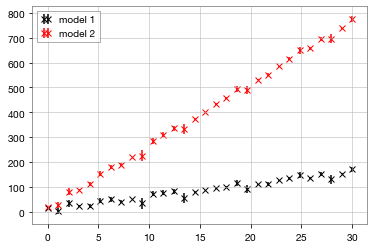

In [21]:
#define the two models

def model_1(x, m, c_1, **kwargs):
    y = m*x + c_1
    return y

def model_2(x, m, c_2, **kwargs):
    y = 5*m*x + c_2
    return y

#make a function to create and plot our data
def make_data(points, m , c_1, c_2, yerr, seed):
    np.random.seed(int(seed))
    xtrue = np.linspace(0,30,points)
    ytrue_1 = model_1(x = xtrue, m = m, c_1 = c_1)
    ytrue_2 = model_2(x = xtrue, m = m, c_2 = c_2)

    yerr = np.random.normal(0,yerr,points)
    xobs = xtrue #no x uncertainty.
    yobs_1 = ytrue_1 + yerr
    yobs_2 = ytrue_2 + yerr
    
    plt.errorbar(xtrue, yobs_1, yerr = yerr, color = 'black', alpha = 1, label = 'model 1', fmt='x')
    plt.errorbar(xtrue, yobs_2, yerr = yerr, color = 'red', alpha = 1, label = 'model 2', fmt='x')
    plt.legend()
    plt.show()
    
    data = {'xtrue': xtrue, 'ytrue_1':ytrue_1, 'ytrue_2':ytrue_2, 'yobs_1':yobs_1, 'yobs_2':yobs_2, 'c_1':c_1,
            'c_2':c_2, 'm':m,'yerr':yerr}
    
    return data

data = make_data(points = 30, m = 5, c_1 = 10, c_2=15, yerr = 10, seed = 1234)

### So we have the data, now lets analyse it with bilby. The setup essentially involves writing down a prior, writing down an individal likelihood, and then multiplying the two likelihoods bilby takes care of the last part.

In [22]:
#define priors for first model.
priors_1 = dict(m=bilby.core.prior.Uniform(0, 20, 'm'),
              c_1=bilby.core.prior.Uniform(0, 20, 'c_1'))
#make priors for the second model.
priors_2 = dict(m=bilby.core.prior.Uniform(0, 20, 'm'),
              c_2=bilby.core.prior.Uniform(0, 20, 'c_2'))

# Bilby will now realise automagically that the two different priors share parameter $m$

### For reasons that should be clear the individual likelihoods in this example are a standard Gaussian likelihoods, if not, i suggest a classic text like Hogg's data analysis recipes.

In [24]:
likelihood_1 = bilby.core.likelihood.GaussianLikelihood(x = data['xtrue'], y = data['yobs_1'], 
                                                        func = model_1, sigma = data['yerr'])
likelihood_2 = bilby.core.likelihood.GaussianLikelihood(x = data['xtrue'], y = data['yobs_2'], 
                                                        func = model_2, sigma = data['yerr'])

### We now set up the joint likelihood infrastructure

In [25]:
joint_likelihood = bilby.core.likelihood.JointLikelihood(likelihood_1, likelihood_2)
priors_joint = priors_1.copy()
priors_joint.update(priors_2)

14:58 bilby INFO    : Running for label 'example', output will be saved to 'joint'
14:58 bilby INFO    : Search parameters:
14:58 bilby INFO    :   m = Uniform(minimum=0, maximum=20, name='m', latex_label='m', unit=None, boundary=None)
14:58 bilby INFO    :   c_1 = Uniform(minimum=0, maximum=20, name='c_1', latex_label='c_1', unit=None, boundary=None)
14:58 bilby INFO    :   c_2 = Uniform(minimum=0, maximum=20, name='c_2', latex_label='c_2', unit=None, boundary=None)
14:58 bilby INFO    : Single likelihood evaluation took 1.907e-04 s
14:58 bilby WARNING : Supplied argument 'npool' not an argument of 'Nestle', removing.
14:58 bilby WARNING : Supplied argument 'resume' not an argument of 'Nestle', removing.
14:58 bilby INFO    : Using sampler Nestle with kwargs {'method': 'multi', 'npoints': 200, 'update_interval': None, 'npdim': None, 'maxiter': None, 'maxcall': None, 'dlogz': None, 'decline_factor': None, 'rstate': None, 'callback': <function print_progress at 0x7fba54df3bf8>, 'steps':

it=  3989 logz=-201.3243660413972


14:58 bilby INFO    : Sampling time: 0:00:11.794902
14:59 bilby INFO    : Summary of results:
nsamples: 4190
ln_noise_evidence:    nan
ln_evidence: -200.963 +/-  0.297
ln_bayes_factor:    nan +/-  0.297



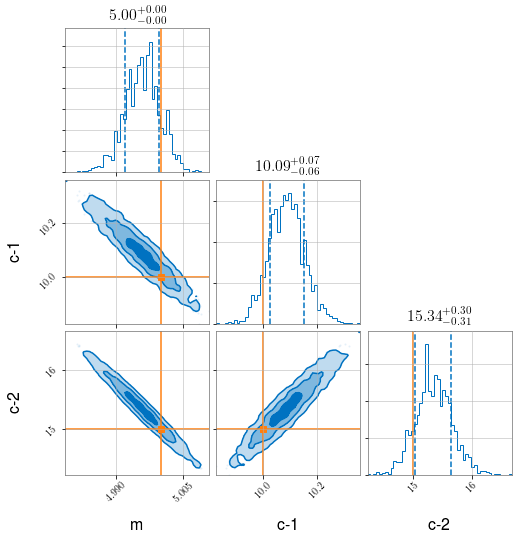

In [29]:
#define injection parameters dict so that they show up in corner
# set up bilby things
outdir = 'joint'
label = 'example'
nlive = 200
walks = 100
injection_parameters = dict(m=data['m'],c_1=data['c_1'],c_2=data['c_2'])

result = bilby.run_sampler(joint_likelihood, priors=priors_joint, label=label, sampler='nestle', nlive=nlive,
                               outdir=outdir, plot=True, use_ratio=False, walks = walks, resume = True, 
                               injection_parameters = injection_parameters)
result.plot_corner()